In [2]:
from __future__ import annotations
from IPython import get_ipython
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

import scipy.stats as stats
from sklearn.metrics import auc
from scipy.stats import chisquare

In [5]:
def assign_variant_on_distribution(users, variants_dict, random_seed=42):
    np.random.seed(random_seed)
    sorted_variants = sorted(variants_dict.keys())
    sorted_ps = [variants_dict[x] for x in sorted_variants]
    unique_users = pd.DataFrame({"user_id":users, 
                            "variant":np.random.choice(sorted_variants, size=len(users), p=sorted_ps)})
    
    return unique_users

def randomization_sim_test(users, variants_dict, random_seed=42):
    unique_users = assign_variant_on_distribution(users=users, variants_dict=variants_dict, random_seed=random_seed)
    sorted_variants = sorted(variants_dict.keys())
    sorted_ps = [variants_dict[x] for x in sorted_variants]
    obs_freqs = unique_users.groupby("variant").count()["user_id"]
    exp_freq = np.array(sorted_ps)*len(users)

    return chisquare(obs_freqs, exp_freq)

## Chi-squared test

We'll perform a chi-squared test to check if the randomization of users is correct

In [6]:
base_path = os.path.abspath('')
all_data = True

events_df = pd.read_csv(f"{base_path}/Data/events_complete.csv")

events_df.head()

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,time,date,sales,event_type_cart,event_type_purchase,event_type_remove_from_cart,event_type_view
0,2019-10-01 00:00:00 UTC,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:00+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0
1,2019-10-01 00:00:03 UTC,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:03+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0
2,2019-10-01 00:00:07 UTC,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:07+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0
3,2019-10-01 00:00:07 UTC,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:07+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0
4,2019-10-01 00:00:15 UTC,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:15+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0


auc p-value: 0.504074228783937


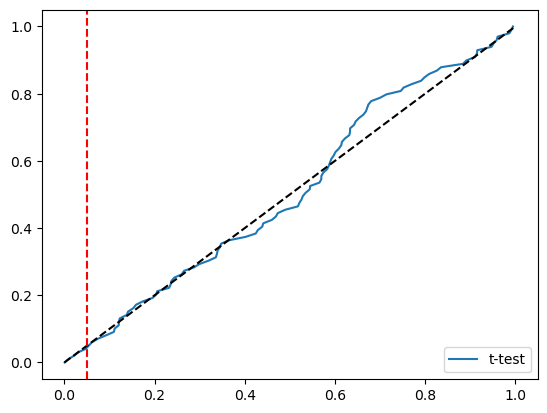

In [ ]:
simulations = 1000
variants = {
    'control':      0.5, 
    'treatment_2':  0.2, 
    "treatment_3":  0.2,  
    "treatment_1":  0.1, 
              }

p_values = []
users = events_df["user_id"].unique()

for i in range(simulations):
    p_values.append(randomization_sim_test(users=users, variants_dict=variants, random_seed=i)[1])

auc_value = auc(sorted(p_values), np.linspace(0, 1, simulations))
print(f"auc p-value: {auc_value}")

fig, ax = plt.subplots()
ax.plot(sorted(p_values), np.linspace(0, 1, simulations), label="t-test")
ax.legend()
ax.plot([0,1],[0,1], '--k')
ax.axvline(0.05, ls='--', color="red")

### Daily test

#### AA

In [8]:
variants = {
    'control':      0.5, 
    'treatment_2':  0.2, 
    "treatment_3":  0.2,  
    "treatment_1":  0.1, 
              }

users = events_df["user_id"].unique()
unique_users = assign_variant_on_distribution(users=users, variants_dict=variants, random_seed=0)
daily_users_variant = events_df[["user_id", "date"]].drop_duplicates().merge(unique_users, on="user_id", how="left")

auc p-value: 0.5169199233888452


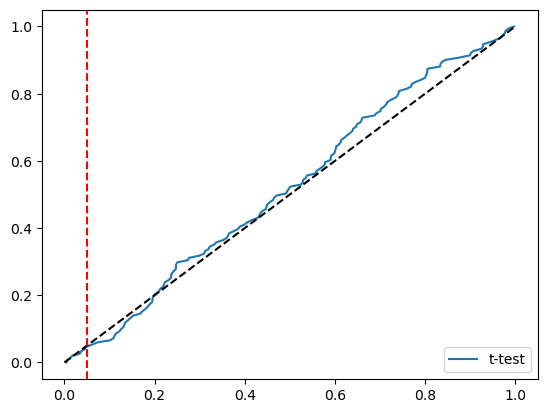

In [9]:
sorted_variants = sorted(variants.keys())
sorted_ps = [variants[x] for x in sorted_variants]
dates = daily_users_variant["date"].unique()
p_values_daily = []

for d in dates:
    this_day_users = daily_users_variant.loc[daily_users_variant["date"]==d]
    obs_freqs = this_day_users.groupby("variant").count()["user_id"]
    exp_freq = np.array(sorted_ps)*len(this_day_users)
    p_values_daily.append(chisquare(obs_freqs, exp_freq)[1])

auc_value = auc(sorted(p_values_daily), np.linspace(0, 1, len(dates)))
print(f"auc p-value: {auc_value}")

fig, ax = plt.subplots()
ax.plot(sorted(p_values_daily), np.linspace(0, 1, len(dates)), label="t-test")
ax.legend()
ax.plot([0,1],[0,1], '--k')
ax.axvline(0.05, ls='--', color="red")

#### AB

In [19]:
exp_ps = []
np.random.seed(0)


for p in sorted_ps:
    exp_ps.append(np.random.normal(p, p/100))

exp_ps[-1] = 1-sum(exp_ps[:-1])
exp_ps

[0.5088202617298383,
 0.10040015720836723,
 0.20195747596821148,
 0.188822105093583]

auc p-value: 0.986675048112632


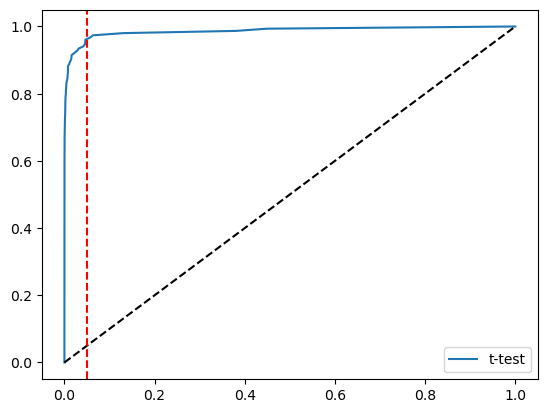

In [24]:
p_values_daily = []

for d in dates:
    this_day_users = daily_users_variant.loc[daily_users_variant["date"]==d]
    obs_freqs = this_day_users.groupby("variant").count()["user_id"]
    exp_freq = np.array(exp_ps)*len(this_day_users)
    p_values_daily.append(chisquare(obs_freqs, exp_freq)[1])

auc_value = auc(sorted(p_values_daily + [1]), np.linspace(0, 1, len(dates)+1))
print(f"auc p-value: {auc_value}")

fig, ax = plt.subplots()
ax.plot(sorted(p_values_daily + [1]), np.linspace(0, 1, len(dates)+1), label="t-test")
ax.legend()
ax.plot([0,1],[0,1], '--k')
ax.axvline(0.05, ls='--', color="red")

A little change in the distribution can be easily detected